0.13976512875119262
0.23336891385367486


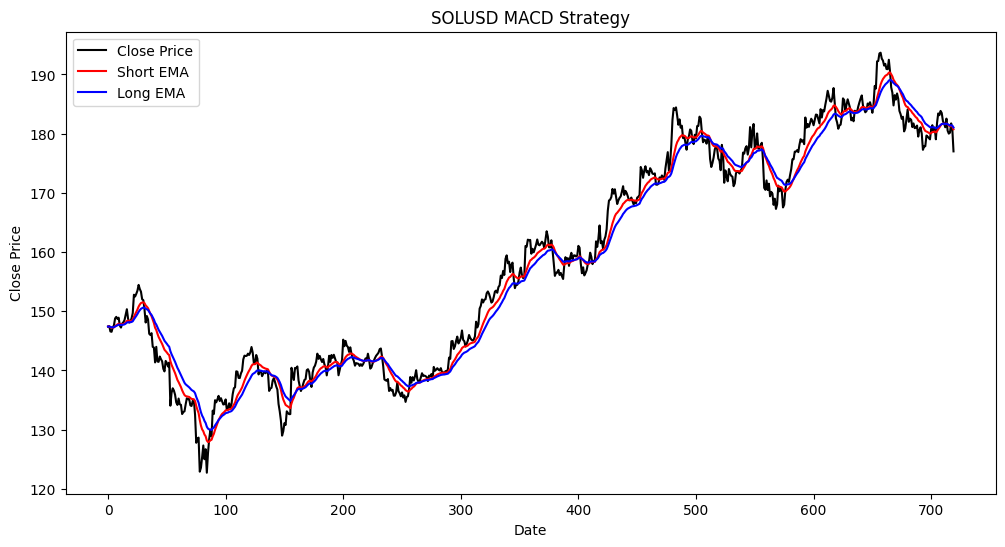

In [46]:
# cacl macd strategy output and return the result
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

# get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair":"SOLUSD","interval":"60"}
headers = {
  'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']['SOLUSD'], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)
#  iterate through testing evm spans 1-100  
df['short_ema'] = df['close'].ewm(span=16, adjust=False).mean()
df['long_ema'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['short_ema'] - df['long_ema']
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

df['hist'] = df['macd'] - df['signal']

# calculate the buy and sell signals on the following:
# buy when the macd crosses above the signal line, and the histogram is negative and when the short ema is above the long ema
# sell when the macd crosses below the signal line and the histogram is positive and when the short ema is below the long ema
df['buy'] =  (df['short_ema'] > df['long_ema'])
df['sell'] = (df['short_ema'] < df['long_ema'])

# calculate the returns
df['return'] = df['close'].pct_change()
# the return should be the return from the buy signal to the sell signal
df['strategy'] = df['return'] * df['buy'].shift(1)

# print the result
print(df['strategy'].sum())
# print the result of only buys assuming I can't short the asset
print(df['return'][df['buy']].sum())

# plot the result
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Close Price', color='black')

# plot the short and long ema
plt.plot(df['short_ema'], label='Short EMA', color='red')
plt.plot(df['long_ema'], label='Long EMA', color='blue')

# add the buy and sell signals
# plt.plot(df[df['buy']].index, df['close'][df['buy']], '^', markersize=10, color='g', lw=0, label='Buy Signal')
# plt.plot(df[df['sell']].index, df['close'][df['sell']], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('SOLUSD MACD Strategy')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.legend()
plt.show()




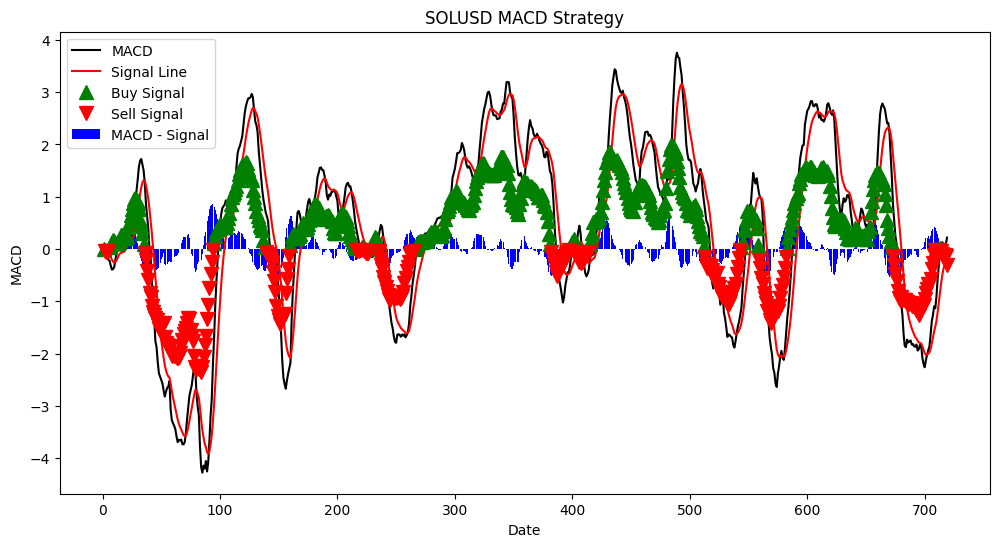

In [47]:
# plot the buy and sell signals on the macd and signal line
plt.figure(figsize=(12,6))
plt.plot(macd, label='MACD', color='black')
plt.plot(signal, label='Signal Line', color='red')
plt.bar(df.index, df['hist'], label='MACD - Signal', color='blue')
# add the buy and sell signals
plt.plot(df[df['buy']].index, df['macd'][df['buy']], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['sell']].index, df['macd'][df['sell']], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('SOLUSD MACD Strategy')
plt.xlabel('Date')
plt.ylabel('MACD')

plt.legend()
plt.show()


In [48]:
# what is the return of the strategy if we cant short the asset

